In [7]:
import pandas as pd
import numpy as np
from pprint import pprint
from nltk import text


df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)
diccionario = pd.read_csv('diccionario_titulos.csv')

In [8]:
import re
def general(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))
        txt = re.sub(r'[^\w\s:.)-]', '', txt)

    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt

dfLimpio = df1.apply(general)

In [9]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('\d{2,10}','',text)
    text = re.sub('\d\n','',text)
    text = re.sub(' +\n','\n',text)
    text = re.sub('\n+','\n',text)
    text = re.sub('\n',' \n',text)
    text = re.sub('\d \n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub(r'[nN]º|[nN][. ]º','',text)
    text = re.sub('[a-zA-Z]+.com','',text)
    #text = re.sub('[\.)-]+[\s]{0,3}','-',text) #PRUEBA PARA NORMALIZAR NRO ROMANO.
    return text

dfPrueba = dfLimpio.apply(limpiarTexto2)

In [10]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return ' '.join(texto)

dfLimpio = dfLimpio.apply(remove_stops)

In [11]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[.) -]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfPrueba:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)

## Busqueda de titulos en mayusculas y numeros latinos

In [12]:
# Busca títulos en mayusculas
def buscarTitulosLatinosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'[0-9][.) -]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())
            i=i+1

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosLatinosMayusculas=[]
for expediente in dfPrueba:
    if len(buscarTitulosLatinosMayusculas(expediente)) > 3:
        titulosLatinosMayusculas.append(buscarTitulosLatinosMayusculas(expediente))

In [172]:
def crearDic(dic):
    dic = re.sub(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+','',dic)
    dic = re.sub(r'[^\w\s -]','',dic)
    dic = re.sub(r'\d','',dic)
    dic = re.sub(r'-',' ',dic)
    dic = dic.lower()
    dic = remove_stops(dic)
    dic = dic.upper()
    dic = dic.split(sep=' ')
    dic = [i for i in dic if len(i) > 3]
    return dic

dicTitulos = crearDic(str(titulosMayusculas))
dicTitulosLatinos = crearDic(str(titulosLatinosMayusculas))

In [ ]:
dicTitulosLatinos

In [161]:
from nltk import text
tokens=dicTitulos
texto_nltk=nltk.Text(tokens)


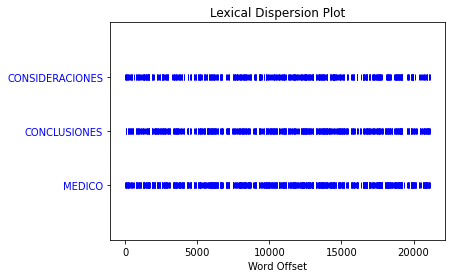

In [150]:
texto_nltk.dispersion_plot(['CONSIDERACIONES', 'CONCLUSIONES', 'MEDICO'])

In [171]:
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

distCos= cosine()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U25'), dtype('<U25')) -> dtype('<U25')

In [ ]:
dfDic = pd.DataFrame(dicTitulos, columns=['token'])

In [ ]:
dfDic.to_csv('diccionario_titulos.csv',index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100000,
                                 min_df=0.2, stop_words=stops,
                                 use_idf=True, ngram_range=(1,5))

tfidf_matrix = tfidf_vectorizer.fit_transform(titM) #fit the vectorizer to dfLimpio

print(tfidf_matrix.shape)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

text = dicTitulos
text = str(text)
coun_vect = CountVectorizer()
count_matrix = coun_vect.fit_transform(text.split())
count_array = count_matrix.toarray()
df = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names())
print(df)

       aa  aaec  aar  ab  abdomen  abodarje  abor  abordaje  absoluto  abuse  \
0       0     0    0   0        0         0     0         0         0      0   
1       0     0    0   0        0         0     0         0         0      0   
2       0     0    0   0        0         0     0         0         0      0   
3       0     0    0   0        0         0     0         0         0      0   
4       0     0    0   0        0         0     0         0         0      0   
...    ..   ...  ...  ..      ...       ...   ...       ...       ...    ...   
21126   0     0    0   0        0         0     0         0         0      0   
21127   0     0    0   0        0         0     0         0         0      0   
21128   0     0    0   0        0         0     0         0         0      0   
21129   0     0    0   0        0         0     0         0         0      0   
21130   0     0    0   0        0         0     0         0         0      0   

       ...  vital  vivencial  viviana  